In [2]:
from pacman import *
import numpy as np
import random
import math
import util
from game import Directions
from game import Agent
import matplotlib.pyplot as plt 

# 3. Part II - Aprendizado por reforço

Nesta seção, realizamos experimentos de aprendizagem por reforço para os mesmo três layouts analisados com programação genética. O algoritmo de aprendizado por reforço escolhido foi o q-learning. 
À princípio, escolhemos uma formulação que gerou um espaço de estados muito grande. Por consequência, o processo de treinamento muito rapidamente estourou a capacidade de memória das máquinas em que os experimentos foram realizados. Isso fez com que fosse possível treinar apenas com um número reduzido de episódios, em espeical os layouts maiores. (1000 episódios para o layout smallClassic, ??? para o mediumClassic e ??? para o originalClassic).
Essa limitação nos impulsionou a tentar uma modelagem alternativa, com espaço de estados de tamanho reduzido. Nesse segundo caso, foi possível treinar com um número razoavelmente mais significativo de episódios (XXX para o layout smallClassic, XXX para o mediumClassic e XXX para o originalClassic)

Além disso, fizemos também uma implementação do q-learning com aproximador de função. Para esse caso, os estados foram representados como uma combinação de features, cada feature sendo associada a um peso, e a qtable foi atualizada a partir de uma combinação linear das features. 

## 3.1 Q-learning
Nesta subseção, apresentamos as duas tentativas realizadas utilizando o algoritmo q-learning. Em ambas, a política de exploração adotada foi $\epsilon$-greedy. Além disso, a atualização da q-table foi feita a partir da seguinte fórmula:

$$
Q(s,a) = Q(s,a) + \alpha [R(s,a) + \gamma\max_{a^\prime} Q(s^\prime, a^\prime) - Q(s,a)],
$$

em que:
$s$ é o estado atual,
$a$ é a ação tomada,
$s^\prime$ é o estado obtido após tomar a ação $a$, e
$R(s,a)$ é o reforço obtido ao alcançar o estado $s^\prime$,
$\alpha$ é a taxa de aprendizado, e
$\gamma$ é o índice de desconto.

### 3.1.1 Primeira formulação
Nessa primeira tentativa, tentamos utilizar como referência todas as informações contidas no labirinto todo.
A seguir, apresentamos a formulação de Markov adotada. 

##### $\rightarrow$ Espaço de estados
Um estado é definifo basicamente como uma fotografia do tabuleiro em um dado instante de tempo. Ele contém:
- a posição do pacman;
- as posições dos itens de comida;
- as posições das cápsulas;
- as posições dos fantasmas ativos;
- as posições dos fantasmas comestíveis;
- as posições das paredes;
- as posições "vazias".

Na nossa implementação, representamos cada estado por uma string, em que cada caractere representa uma posição do tabuleiro e indica qual tipo de objeto está naquela posição, naquele estado. A relação entre caracteres e tipo de objeto é dada da seguinte forma:
- P: pacman;
- F: item de comida;
- C: cápsula;
- A: fantasma ativos;
- S: fantasma comestível;
- W: parede;
- E: posições vazias.

Seja $m$ e $n$ as dimensões de um dado layout. Note que, nessa formulação, o número de estados diferentes é dado pelo número de permutações possíveis, de tamanho $m \times n$, do conjunto de caracteres necessários para representar um estado. Essa quantidade de estados diferentes é bastante grande.

##### $\rightarrow$ Espaço de ações
Cada ação é um dos movimentos que o pacman pode realizar. São elas:
- NORTH,
- SOUTH,
- WEST,
- EAST,
- STOP.
    
##### $\rightarrow$ Função de reforço
Para cada ação que o pacman pode realizar, associamos um valor de reforço. O reforço referente ao passar do tempo, de -1 para cada passo, já vem com o funcionamento padrão do framework utilizado. Os reforços foram definidos da seguinte maneira:
- +500, quando a ação resulta em uma vitória do pacman;
- -500, quando a ação resulta em uma derrota do pacman;
- +10, quando a ação do pacman resulta no consumo de um item de comida;
- +100, quando a ação do pacman resulta no consumo de uma cápsula;
- +200, quando a ação do pacman resulta no consumo de um fantasma comestível;
- -1, quando o pacman não se movimenta;
- 0, caso contrário.

##### $\rightarrow$ Episódios  e critério de parada
Um episódio se encerra (critério de parada) quando o pacman ganha ou perde o jogo.
Com essa primeira formulação, conseguimos treinar com um número diferente de episódios para cada layout. Essa informação se encontra na subseção em que relatamos os experimentos realizados.

##### $\rightarrow$ Parâmetros utilizados
Para todos os layouts, utilizamos os seguintes parâmetros para implementação do q-learning:
- taxa de aprendizado: alpha = 0.5,
- índice de desconto: gamma = 0.8.

Além disso, como utilizamos a política $\epsilon$-greedy, foi preciso ajustar também o seguinte parâmetro:
- taxa de exploração: epsilon = 0.2, decaindo de 0.001 até chegar em zero ou o treinamento se encerrar.

### 3.1.2 Segunda formulação
Nessa segunda tentativa, tentamos utilizar como referência todas as informações contidas apenas no entorno da posição atual do pacman, adotando a ideia de vizinhança-8. Ou seja, supondo que o pacman está na posição $(x,y)$, um estado é formado pelas seguintes posições: 

$(x+1,y-1)$, $(x+1,y)$, $(x+1,y+1)$, $(x,y-1)$, $(x,y+1)$, $(x-11,y-1)$, $(x-1,y)$ e $(x-1,y+1)$. 

No framework adotado para executar o jogo do pacman, o grid que representa um layout segue como referência o plano euclidiano (discretizado), com a origem posicionada no canto inferior esquerdo, o eixo evrtical crescento para cima e o eixo horizontal crescendo para a direita. 
A seguir, apresentamos a formulação de Markov adotada. Note que, esse padrão não é o normalmente utilizado para indexar matrizes, no entanto, por simplicidade, optamos por seguir o padrão do modelo.

##### $\rightarrow$ Espaço de estados
Similarmente à tentativa anterior, um estado é definifo basicamente como uma fotografia do entorno do pacman em um dado instante de tempo. Ele contém:
- a posição do pacman;
- as posições dos itens de comida;
- as posições das cápsulas;
- as posições dos fantasmas ativos;
- as posições dos fantasmas comestíveis;
- as posições das paredes;
- as posições "vazias".

Novamente, representamos cada estado por uma string, em que cada caractere representa uma posição do tabuleiro e indica qual tipo de objeto está naquela posição, naquele estado. Além dos caracteres listados na subseção anterior, para essa formulação, precisamos de um caractere extra que represente os limites do tabuleiro. Ou seja, as posições ao entorno do pacman que se encontram fora do limite do tabuleiro são marcadas com o caratere 'O'. Note que, nessa formulação, um estado é representado por uma string de oito caracteres. Observe que, nessa formulação, o número de estados diferentes é dado pelo número de permutações possíveis, de tamanho oito, do conjunto de caracteres necessários para representar um estado. Assim, o número de estados diferentes nessa formulação é  significativamente menor que o número de estados diferentes possíveis na formulação da tentativa anterior.

##### $\rightarrow$ Espaço de ações
Cada ação é um dos movimentos que o pacman pode realizar. São elas:
- NORTH,
- SOUTH,
- WEST,
- EAST,
- STOP.
    
##### $\rightarrow$ Função de reforço
Para cada ação que o pacman pode realizar, associamos um valor de reforço. O reforço referente ao passar do tempo, de -1 para cada passo, já vem com o funcionamento padrão do framework utilizado. Os reforços foram definidos da seguinte maneira:
- +500, quando a ação resulta em uma vitória do pacman;
- -500, quando a ação resulta em uma derrota do pacman;
- +10, quando a ação do pacman resulta no consumo de um item de comida;
- +100, quando a ação do pacman resulta no consumo de uma cápsula;
- +200, quando a ação do pacman resulta no consumo de um fantasma comestível;
- -1, quando o pacman não se movimenta;
- 0, caso contrário.

##### $\rightarrow$ Episódios  e critério de parada
Um episódio se encerra (critério de parada) quando o pacman ganha ou perde o jogo. O número de episódios utilizados para o treinamento está apresentado na subseção em que relatamos os experimentos realizados com essa formulação.

##### $\rightarrow$ Parâmetros utilizados
Para todos os layouts, utilizamos os seguintes parâmetros para implementação do q-learning:
- taxa de aprendizado: alpha = 0.5,
- índice de desconto: gamma = 0.8.

Além disso, como utilizamos a política $\epsilon$-greedy, foi preciso ajustar também o seguinte parâmetro:
- taxa de exploração: epsilon = 0.2, decaindo de 0.001 até chegar em zero ou o treinamento se encerrar.

## 3.2 Q-learning com aproximador de função
Nesta subseção, apresentamos a nossa tentativa de implementar o algoritmo q-learning com aproximador de função. Nesse caso, foi necessário definir *features* associadas a um par estado-ação. A ideia é que cada uma dessas *features* seja associada a um peso e, então, o q-value é atualizado como uma combinação linear dos valores das *features*. Assim, a q-table é atualizada da seguinte forma:

$$
Q(s,a) = \sum_{i=1}^n w_i f_i (s,a),
$$

em que: $s$ é o estado atual, $a$ é a ação tomada, $w_i$ é o peso da $i$-ésima *feature* e $f_i (s,a)$ é o valor da $i$-ésima *feature* para o par estado-ação $s$-$a$.

Os pesos também devem ser atualizados a cada episódio e é justamente na atualização dos pesos que são considerados o reforço e a previsão do melhor futuro possível. Cada pesso $w_i$ é atualizado da seguinte forma:

$$
w_i = w_i + \alpha [R(s,a) + \gamma\max_{a^\prime} Q(s^\prime, a^\prime) - Q(s,a)] f_i(s,a),
$$

em que: $R(s,a)$ é o reforço associado ao estado $s^\prime$, $\alpha$ é a taxa de aprendizado e $\gamma$ é o índice de desconto.


Para escolher as *features* nos baseamos no trabalho [8]. A seguir, apresentamos as *features* definidas, bem como demais componentes da formulação. Todas as distâncias foram calculadas como distância de Manhattan.

##### $\rightarrow$ Features
- Distancia para o item de comida mais próximo.
- Distância para o fantasma comestível mais próximo.
- Distância para o fantasma ativo mais próximo.
- Progresso da partida, dado pela razão entre o número total de itens de comida e o número de itens consumidos.
- Se o pacman comeu uma cápsula, tempo restante até que os fantasmas deixem de ser comestíveis.

##### $\rightarrow$ Espaço de ações
Cada ação é um dos movimentos que o pacman pode realizar. São elas:
- NORTH,
- SOUTH,
- WEST,
- EAST,
- STOP.
    
##### $\rightarrow$ Função de reforço
Para cada ação que o pacman pode realizar, associamos um valor de reforço. O reforço referente ao passar do tempo, de -1 para cada passo, já vem com o funcionamento padrão do framework utilizado. Os reforços foram definidos da seguinte maneira:
- +500, quando a ação resulta em uma vitória do pacman;
- -500, quando a ação resulta em uma derrota do pacman;
- +10, quando a ação do pacman resulta no consumo de um item de comida;
- +100, quando a ação do pacman resulta no consumo de uma cápsula;
- +200, quando a ação do pacman resulta no consumo de um fantasma comestível;
- -1, quando o pacman não se movimenta;
- 0, caso contrário.

##### $\rightarrow$ Episódios  e critério de parada
Um episódio se encerra (critério de parada) quando o pacman ganha ou perde o jogo. O número de episódios utilizados para o treinamento está apresentado na subseção em que relatamos os experimentos realizados com essa formulação.

##### $\rightarrow$ Parâmetros utilizados
Para todos os layouts, utilizamos os seguintes parâmetros para implementação do q-learning:
- taxa de aprendizado: alpha = 0.5,
- índice de desconto: gamma = 0.8.

Além disso, como utilizamos a política $\epsilon$-greedy, foi preciso ajustar também o seguinte parâmetro:
- taxa de exploração: epsilon = 0.2, decaindo de 0.001 até chegar em zero ou o treinamento se encerrar.

## 3.3 Código-fonte

A seguir, apresentamos todo o código-fonte referentes à parte $II$ do projeto.

In [20]:
class RLAgent_mini(Agent):
    qtable = {}
    alpha = 0.1
    gamma = 0.8
    epsilon = 0.2
    scores_list = []
    nsteps_list = []
    result_list = []
    reward_list = []
    episode_reward = 0
    m = 0
    n = 0
        
    def calculateReward(self, state, future_state):
        future_pacman = list(future_state.getPacmanPosition())
        reward = 0
        if future_state.isWin(): #pacman ganhou
            reward = 500
        if future_state.isLose(): #pacman perdeu
            reward = -500
        if state.hasFood(future_pacman[0], future_pacman[1]): #comeu um item de comida
            reward = 10
        if future_state.getPacmanPosition() in state.getCapsules(): #comeu uma cápsula
            reward = 100
        for i in range(1,state.getNumAgents()): #comeu fantasma assustado
            if (future_pacman[0], future_pacman[1]) == state.getGhostPosition(i) and state.data.agentStates[i].scaredTimer > 1:
                reward = 200
        if state.getPacmanPosition() == future_state.getPacmanPosition(): #não se mexeu
            reward = -1
        
        return reward
    
    def update(self, state, action, qstate):
        future_state = state.generatePacmanSuccessor(action)
        
        reward = self.calculateReward(state, future_state)
        self.episode_reward += reward  
        
        if (future_state.isWin() or future_state.isLose()):
            max_future = 0
        else:
            future_qstate = generate_qstate_key(future_state, self.m, self.n)       
            future_action = self.getBestActionFromQtable(future_state, future_qstate)
            max_future = self.qtable[(future_qstate,future_action)]
        
        if (qstate,action) not in self.qtable:
                self.qtable[(qstate,action)] = 0
        old_value = self.qtable[(qstate,action)]
        
        new_value = old_value + self.alpha*(reward + self.gamma*max_future - old_value)
        self.qtable[(qstate,action)] = new_value
    
    def getBestActionFromQtable(self, state, qstate):
        best_action = Directions.STOP
        max_qvalue = -math.inf
        
        legalActions = state.getLegalPacmanActions()
        for action in legalActions:
            if (qstate,action) not in self.qtable:
                self.qtable[(qstate,action)] = 0
            if self.qtable[(qstate,action)] > max_qvalue:
                max_qvalue = self.qtable[(qstate,action)]
                best_action = action
            
        return best_action
    
    def getQAction(self, state, qstate):
        legalActions = state.getLegalPacmanActions()
        
        # epsilon-greedy policy
        p = random.random()
        if p < self.epsilon:
            action = random.choice(legalActions)
        else:
            action = self.getBestActionFromQtable(state, qstate)
        
        return action
   
    
    def getAction(self, state):
        qstate = generate_qstate_key(state, self.m, self.n)
        action = self.getQAction(state, qstate)
        self.update(state, action, qstate)
        return action
        
        
        
def get_qstate_key_char(state, x, y):
    
    if (x,y) in state.getGhostPositions():
        c = 'A' # fantasma ativo
        for i in range(1,state.getNumAgents()):
            if (x,y) == state.getGhostPosition(i) and state.data.agentStates[i].scaredTimer > 1:
                c = 'S' # fantasma assustado
        return c
    elif (x,y) in state.getCapsules():
        return 'C'
    elif (state.hasFood(x,y)):
        return 'F'
    elif (state.hasWall(x,y)):
        return 'W'
    elif (x,y) == state.getPacmanPosition():
        return 'P'
    else:
        return 'E'

def generate_qstate_key(state, m, n):
    key = ['O','O','O','O','O','O','O','O']
    pacman = list(state.getPacmanPosition())
    
    # canto superior esquerdo key[0]
    x = pacman[0]-1
    y = pacman[1]+1
    if x >= 1 and y <= m:
        key[0] = get_qstate_key_char(state, x, y)
    
    # meio superior key[1]
    x = pacman[0]
    y = pacman[1]+1
    if y <= m:
        key[1] = get_qstate_key_char(state, x, y)
        
    # canto superior direito key[2]
    x = pacman[0]+1
    y = pacman[1]+1
    if x <= n and y <= m:
        key[2] = get_qstate_key_char(state, x, y)
    
    # meio esquerdo key[3]
    x = pacman[0]-1
    y = pacman[1]
    if x >= 1:
        key[3] = get_qstate_key_char(state, x, y)

    # meio direito key[4]
    x = pacman[0]+1
    y = pacman[1]
    if x <= n:
        key[4] = get_qstate_key_char(state, x, y)
    
    # canto inferior esquerdo key[5]
    x = pacman[0]-1
    y = pacman[1]-1
    if x >= 1 and y >=1:
        key[5] = get_qstate_key_char(state, x, y)
        
    # meio inferior key[6]
    x = pacman[0]
    y = pacman[1]-1
    if y >= 1:
        key[6] = get_qstate_key_char(state, x, y)
    
    # canto inferior direito key[7]
    x = pacman[0]+1
    y = pacman[1]-1
    if x <= n and y >= 1:
        key[7] = get_qstate_key_char(state, x, y)
    
    return ''.join(key)

In [21]:
class RLAgent_full(Agent):
    qtable = {}
    alpha = 0.1
    gamma = 0.8
    epsilon = 0.2
    scores_list = []
    nsteps_list = []
    result_list = []
    reward_list = []
    episode_reward = 0
    m = 0
    n = 0
        
    def calculateReward(self, state, future_state):
        future_pacman = list(future_state.getPacmanPosition())
        reward = 0
        if future_state.isWin(): #pacman ganhou
            reward = 500
        if future_state.isLose(): #pacman perdeu
            reward = -500
        if state.hasFood(future_pacman[0], future_pacman[1]): #comeu um item de comida
            reward = 10
        if future_state.getPacmanPosition() in state.getCapsules(): #comeu uma cápsula
            reward = 100
        for i in range(1,state.getNumAgents()): #comeu fantasma assustado
            if (future_pacman[0], future_pacman[1]) == state.getGhostPosition(i) and state.data.agentStates[i].scaredTimer > 1:
                reward = 200
        if state.getPacmanPosition() == future_state.getPacmanPosition(): #não se mexeu
            reward = -1
        
        return reward
    
    def update(self, state, action, qstate):
        future_state = state.generatePacmanSuccessor(action)
        
        reward = self.calculateReward(state, future_state)
        self.episode_reward += reward
        
        if (future_state.isWin() or future_state.isLose()):
            max_future = 0
        else:
            future_qstate = _generate_qstate_key(future_state, self.m, self.n)       
            future_action = self.getBestActionFromQtable(future_state, future_qstate)
            max_future = self.qtable[(future_qstate,future_action)]
        
        if (qstate,action) not in self.qtable:
                self.qtable[(qstate,action)] = 0
        old_value = self.qtable[(qstate,action)]
        
        new_value = old_value + self.alpha*(reward + self.gamma*max_future - old_value)
        self.qtable[(qstate,action)] = new_value
    
    def getBestActionFromQtable(self, state, qstate):
        best_action = Directions.STOP
        max_qvalue = -math.inf
        
        legalActions = state.getLegalPacmanActions()
        for action in legalActions:
            if (qstate,action) not in self.qtable:
                self.qtable[(qstate,action)] = 0
            if self.qtable[(qstate,action)] > max_qvalue:
                max_qvalue = self.qtable[(qstate,action)]
                best_action = action
            
        return best_action
    
    def getQAction(self, state, qstate):
        legalActions = state.getLegalPacmanActions()
        
        # epsilon-greedy policy
        p = random.random()
        if p < self.epsilon:
            action = random.choice(legalActions)
        else:
            action = self.getBestActionFromQtable(state, qstate)

        return action
   
    
    def getAction(self, state):
        qstate = _generate_qstate_key(state, self.m, self.n)
        action = self.getQAction(state, qstate)
        self.update(state, action, qstate)
        return action     

        
def _get_qstate_key_char(state, x, y):
    if (x,y) in state.getGhostPositions():
        c = 'A' # fantasma ativo
        for i in range(1,state.getNumAgents()):
            if (x,y) == state.getGhostPosition(i) and state.data.agentStates[i].scaredTimer > 1:
                c = 'S' # fantasma assustado
        return c
    elif (x,y) in state.getCapsules():
        return 'C'
    elif (state.hasFood(x,y)):
        return 'F'
    elif (state.hasWall(x,y)):
        return 'W'
    elif (x,y) == state.getPacmanPosition():
        return 'P'
    else:
        return 'E'

def _generate_qstate_key(state, m, n):
    qstate = []
    for i in range(0,m):
        for j in range(0,n):
            qstate.append(_get_qstate_key_char(state, i, j))
    
    return ''.join(qstate)
  
def print_episodes_graph(n_episodes, values, label_y, title):
    ep = list(range(1,n_episodes+1))
    
    plt.plot(ep,values)
    plt.title(title)
    plt.xlabel('Episódios')
    plt.ylabel(label_y)
    plt.grid()
    plt.show()

In [24]:
def _get_qstate_key_char(state, x, y):
    if (x,y) in state.getGhostPositions():
        c = 'A' # fantasma ativo
        for i in range(1,state.getNumAgents()):
            if (x,y) == state.getGhostPosition(i) and state.data.agentStates[i].scaredTimer > 1:
                c = 'S' # fantasma assustado
        return c
    elif (x,y) in state.getCapsules():
        return 'C'
    elif (state.hasFood(x,y)):
        return 'F'
    elif (state.hasWall(x,y)):
        return 'W'
    elif (x,y) == state.getPacmanPosition():
        return 'P'
    else:
        return 'E'

def _generate_qstate_key(state, m, n):
    qstate = []
    for i in range(0,m):
        for j in range(0,n):
            qstate.append(_get_qstate_key_char(state, i, j))
    
    return ''.join(qstate)

def getFeatureCapsule(state, future_state):
    max_scared = 0
    for i in range(1,state.getNumAgents()):
        if state.data.agentStates[i].scaredTimer > max_scared:
            max_scared = state.data.agentStates[i].scaredTimer
    if max_scared > 0:
        return 1 - (39 - max_scared)/39
    else:
        return 0

def getFeatureActive_g(state, future_state):
    nearest_ghost = math.inf
    for i in range(1,state.getNumAgents()):
        if state.data.agentStates[i].scaredTimer <= 1:
            if util.manhattanDistance(state.getPacmanPosition(), state.getGhostPosition(i)) < nearest_ghost:
                nearest_ghost = util.manhattanDistance(state.getPacmanPosition(), state.getGhostPosition(i))
    
    if nearest_ghost != math.inf:
        return nearest_ghost
    else:
        return 0

def getFeatureScared_g(state, future_state):
    nearest_ghost = math.inf
    for i in range(1,state.getNumAgents()):
        if state.data.agentStates[i].scaredTimer > 1:
            if util.manhattanDistance(state.getPacmanPosition(), state.getGhostPosition(i)) < nearest_ghost:
                nearest_ghost = util.manhattanDistance(state.getPacmanPosition(), state.getGhostPosition(i))
    
    if nearest_ghost != math.inf:
        return nearest_ghost
    else:
        return 0

class Params():
    bias = 1
    food = 0
    capsule = 0
    scared_g = 0
    active_g = 0
    proggress = 0

class RL_AQ_Agent(Agent):
    m = 0
    n = 0
    total_food = 0
    epsilon = 0.2
    alpha = 0.001
    gamma = 0.8
    episode_reward = 0
    qtable = {}
    ftable = {}
    wtable = {}
    nsteps_list = []
    reward_list = []
    scores_list = []
    result_list = []
    

    def getFeatureFood(self, state, future_state):
        nearest_food = math.inf
        food = state.getFood()
        for i in range(1,self.m):
            for j in range(1,self.n):
                if food[i][j]:
                    c_food = util.manhattanDistance(state.getPacmanPosition(), (i,j))
                    if c_food < nearest_food:
                        nearest_food = c_food
        
        if nearest_food != math.inf:
            return nearest_food
        else:
            return 0

    def getFeatureProggress(self, future_state):
        return future_state.getNumFood()/self.total_food
    
    def calculateReward(self, state, future_state):
        future_pacman = list(future_state.getPacmanPosition())
        reward = 0
        
        if future_state.isWin(): #pacman ganhou
            reward = 500
        if future_state.isLose(): #pacman perdeu
            reward = -500
        if future_state.getPacmanPosition() in state.getCapsules(): #comeu uma cápsula
            reward = 100
        for i in range(1,state.getNumAgents()): #comeu fantasma assustado
            if (future_pacman[0], future_pacman[1]) == state.getGhostPosition(i) and state.data.agentStates[i].scaredTimer > 1:
                reward = 200
        if state.getPacmanPosition() == future_state.getPacmanPosition(): #não se mexeu
            reward = -1
        if state.hasFood(future_pacman[0], future_pacman[1]): #comeu um item de comida
            reward = 100
        #print("REWARD: ", reward)
        return reward
        
    def calculateFeatures(self, state, action, future_state):
        qstate = _generate_qstate_key(state, self.m, self.n)
        future_qstate = _generate_qstate_key(future_state, self.m, self.n)
                
        if (qstate,action) not in self.ftable:
            self.ftable[(qstate,action)] = Params()
        self.ftable[(qstate,action)].food = self.getFeatureFood(state, future_state)
        self.ftable[(qstate,action)].capsule = getFeatureCapsule(state, future_state)
        self.ftable[(qstate,action)].active_g = getFeatureActive_g(state, future_state)
        self.ftable[(qstate,action)].scared_g = getFeatureScared_g(state, future_state)
        self.ftable[(qstate,action)].proggress = self.getFeatureProggress(future_state)

    def updateQtable(self, state, action):
        #obtain future state
        future_state = state.generatePacmanSuccessor(action)
        future_qstate = _generate_qstate_key(future_state, self.m, self.n)
        current_qstate = _generate_qstate_key(state, self.m, self.n)
        
        #initialize qtable, if necessary
        if (current_qstate,action) not in self.qtable:
            self.qtable[(current_qstate,action)] = 0
        
        #wait for ghosts movements to be complete
        
        #calculate reward
        action_reward = self.calculateReward(state, future_state)
        self.episode_reward += action_reward
        
        #calculate best action for future_state
        if future_state.getLegalPacmanActions() == []:
            future_best_value = 0
        else:
            future_best_action = self.getActionFromQtable(future_state)
            future_best_value = self.qtable[(future_qstate,future_best_action)]
            
        #calculate features
        self.calculateFeatures(state, action, future_state)
        #print("Features: ", self.ftable[(current_qstate,action)].bias)
        #print("Features: ", self.ftable[(current_qstate,action)].food)
        #print("Features: ", self.ftable[(current_qstate,action)].capsule)
        #print("Features: ", self.ftable[(current_qstate,action)].active_g)
        #print("Features: ", self.ftable[(current_qstate,action)].scared_g)
        #print("Features: ", self.ftable[(current_qstate,action)].proggress)
        
        #update weights
        if (current_qstate,action) not in self.wtable:
            self.wtable[(current_qstate,action)] = Params()
        self.wtable[(current_qstate,action)].food += self.alpha*(action_reward + self.gamma*future_best_value - self.qtable[(current_qstate,action)]) * (self.ftable[(current_qstate,action)].food)
        self.wtable[(current_qstate,action)].food += 1
        self.wtable[(current_qstate,action)].capsule += self.alpha*(action_reward + self.gamma*future_best_value - self.qtable[(current_qstate,action)]) * (self.ftable[(current_qstate,action)].capsule)
        self.wtable[(current_qstate,action)].capsule += 1
        self.wtable[(current_qstate,action)].active_g += self.alpha*(action_reward + self.gamma*future_best_value - self.qtable[(current_qstate,action)]) * (self.ftable[(current_qstate,action)].active_g)
        self.wtable[(current_qstate,action)].active_g += 1
        self.wtable[(current_qstate,action)].scared_g += self.alpha*(action_reward + self.gamma*future_best_value - self.qtable[(current_qstate,action)]) * (self.ftable[(current_qstate,action)].scared_g)
        self.wtable[(current_qstate,action)].scared_g += 1
        self.wtable[(current_qstate,action)].proggress += self.alpha*(action_reward + self.gamma*future_best_value - self.qtable[(current_qstate,action)]) * (self.ftable[(current_qstate,action)].proggress)
        self.wtable[(current_qstate,action)].proggress += 1
        #print("Weights: ", self.wtable[(current_qstate,action)].bias)
        #print("Weights: ", self.wtable[(current_qstate,action)].food)
        #print("Weights: ", self.wtable[(current_qstate,action)].capsule)
        #print("Weights: ", self.wtable[(current_qstate,action)].active_g)
        #print("Weights: ", self.wtable[(current_qstate,action)].scared_g)
        #print("Weights: ", self.wtable[(current_qstate,action)].proggress)
        
        #update qtable value
        new_value = self.wtable[(current_qstate,action)].bias*self.ftable[(current_qstate,action)].bias
        new_value += self.wtable[(current_qstate,action)].food*self.ftable[(current_qstate,action)].food
        new_value += self.wtable[(current_qstate,action)].capsule*self.ftable[(current_qstate,action)].capsule
        new_value += self.wtable[(current_qstate,action)].active_g*self.ftable[(current_qstate,action)].active_g
        new_value += self.wtable[(current_qstate,action)].scared_g*self.ftable[(current_qstate,action)].scared_g
        new_value += self.wtable[(current_qstate,action)].proggress*self.ftable[(current_qstate,action)].proggress
        self.qtable[(current_qstate,action)] = new_value
    
    def getActionFromQtable(self, state):
        legalActions = state.getLegalPacmanActions()
        legalActions.remove(Directions.STOP)
        
        qstate = _generate_qstate_key(state, self.m, self.n) #generate state key
        max_qvalue = -math.inf
        best_action = None
        for action in legalActions: #lookup qtable for bet action
            if (qstate,action) not in self.qtable:
                self.qtable[(qstate,action)] = 0
            if self.qtable[(qstate,action)] > max_qvalue:
                max_qvalue = self.qtable[(qstate,action)]
                best_action = action
        
        return action
    
    def getAction(self, state):
        legalActions = state.getLegalPacmanActions()
        
        #epsilon-greedy policy
        if random.random() < self.epsilon:
            action = random.choice(legalActions)
        else:
            action = self.getActionFromQtable(state)
        
        #update qtable
        self.updateQtable(state, action)
        #print(action)
        return action

def print_episodes_graph(n_episodes, values, label_y, title):
    ep = list(range(1,n_episodes+1))
    
    plt.plot(ep,values)
    plt.title(title)
    plt.xlabel('Episódios')
    plt.ylabel(label_y)
    plt.grid()
    plt.show()

In [6]:
# Rodando o melhor modelo RL no smallClassic (grid todo)
class RLplayer(Agent):
    qtable = {}
    m = 0
    n = 0
    scores_list = []
    nsteps_list = []
    result_list = []
    
    def getBestAction(self, state):
        best_action = None
        max_qvalue = -math.inf
        qstate = _generate_qstate_key(state, self.m, self.n)
        legalActions = state.getLegalPacmanActions()           
        for action in legalActions:
            if (qstate,action) not in self.qtable:
                self.qtable[(qstate,action)] = 0
            if self.qtable[(qstate,action)] > max_qvalue:
                max_qvalue = self.qtable[(qstate,action)]
                best_action = action

        return best_action
    
    def getAction(self,state):
        action = self.getBestAction(state)
        return action

## 3.4 Experimentos

Nesta seção, apresentamos os experimentos realizados com os layouts: smallClassic, mediumClassic e originalClassic. Para cada layout, executamos as três formulações descritas na Seção 3.2. Em todos os experimentos, executamos o jogo no modo silencioso, isto é, sem gerar a interface gráfica.

### 3.4.1 Mapa smallClassic
Executamos as três formulações propostas, imprimindo o número de episódios considerado para o treinamento, gráficos de reward por episódio, score por episódio, número de passos por episódio e, finalmente, o número de partidas ganhas.

##### $\rightarrow$ Primeira formulação: q-learning com estados definidos sobre o mapa completo

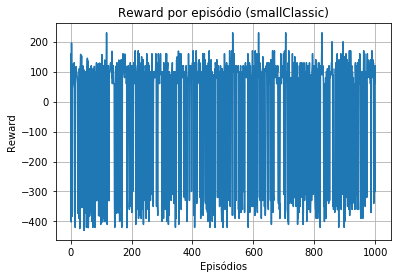

Reward máximo:  230 - Reward mínimo:  -430


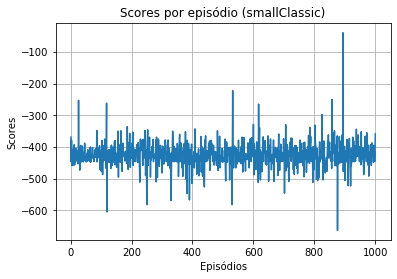

Score máximo:  -40.0 - Score mínimo:  -663.0


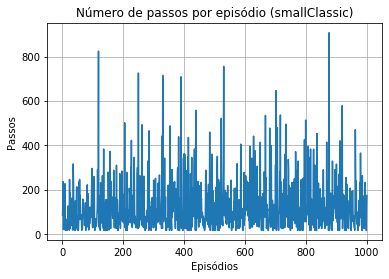

No passos máximo:  907 - No passos mínimo:  18
Número de partidas ganhas:  0


In [13]:
seed = 489216598723
random.seed(seed)
input_str = "-l smallClassic -q"
args = readCommand(input_str.split())
agent = RLAgent_full()
args['pacman'] = agent
layout = args['layout']

# Inicialização do agente
agent.m = layout.width
agent.n = layout.height
agent.reward_list = []
agent.scores_list = []
agent.nsteps_list = []
agent.result_list = []

# Treinamento
n_episodes = 1000
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent.scores_list.append(games[0].state.getScore())
    agent.nsteps_list.append(len(games[0].moveHistory))
    agent.result_list.append(games[0].state.isWin())
    agent.reward_list.append(agent.episode_reward)
    agent.episode_reward = 0
    if agent.epsilon >= 0.001:
        agent.epsilon -= 0.001
        
RL_full_best_small = agent.qtable

# Impressão de estatísticas
print("Treinamento smallClassic com a primeira formulação (mapa completo)")
print("Número de episódios: ", n_episodes)
n_wins = 0
for jogada in agent.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent.reward_list), "-", "Reward mínimo: ", min(agent.reward_list))
print_episodes_graph(n_episodes, agent.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent.scores_list), "-", "Score mínimo: ", min(agent.scores_list))
print_episodes_graph(n_episodes, agent.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent.nsteps_list), "-", "No passos mínimo: ", min(agent.nsteps_list))
#print_episodes_graph(n_episodes, agent.result_list, 'Resultado', 'Resultado final por episódio (smallClassic)')
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Segunda formulação: q-learning com estados definidos sobre o entorno do pacman

Treinamento smallClassic com a segunda formulação (entorno do pacman)
Número de episódios:  1000


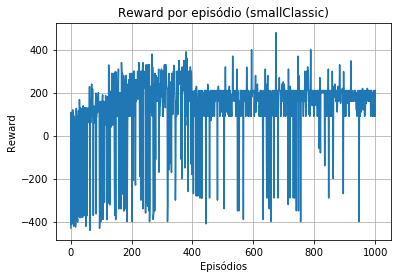

Reward máximo:  479 - Reward mínimo:  -441


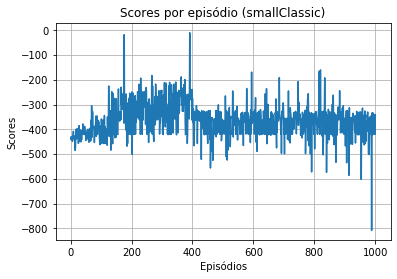

Score máximo:  -10.0 - Score mínimo:  -808.0


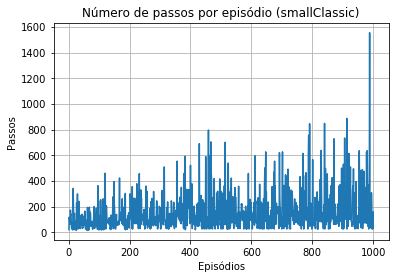

No passos máximo:  1554 - No passos mínimo:  16
Número de partidas ganhas:  0


In [16]:
seed = 7891259193
random.seed(seed)
input_str = "-l smallClassic -q"
args = readCommand(input_str.split())
agent1 = RLAgent_mini()
args['pacman'] = agent1
layout = args['layout']

# Incialização do agente
agent1.m = layout.width
agent1.n = layout.height
agent1.reward_list = []
agent1.scores_list = []
agent1.nsteps_list = []
agent1.result_list = []

# Treinamento
n_episodes = 1000
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent1.scores_list.append(games[0].state.getScore())
    agent1.nsteps_list.append(len(games[0].moveHistory))
    agent1.result_list.append(games[0].state.isWin())
    agent1.reward_list.append(agent1.episode_reward)
    agent1.episode_reward = 0
    if agent1.epsilon >= 0.001:
        agent1.epsilon -= 0.001
    
RL_mini_best_small = agent1.qtable

# Impressão de estatísticas
print("Treinamento smallClassic com a segunda formulação (entorno do pacman)")
print("Número de episódios: ", n_episodes)
n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent1.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent1.reward_list), "-", "Reward mínimo: ", min(agent1.reward_list))
print_episodes_graph(n_episodes, agent1.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent1.scores_list), "-", "Score mínimo: ", min(agent1.scores_list))
print_episodes_graph(n_episodes, agent1.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent1.nsteps_list), "-", "No passos mínimo: ", min(agent1.nsteps_list))
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Terceira formulação: q-learning com aproximador de função

Treinamento smallClassic com a terceira formulação (aproximador de função)
Número de episódios:  100


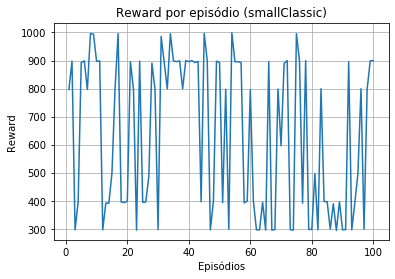

Reward máximo:  999 - Reward mínimo:  296


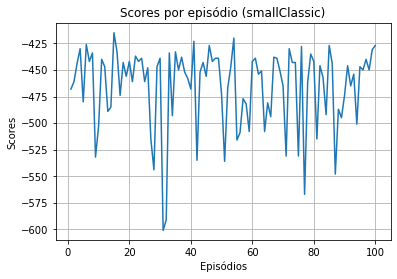

Score máximo:  -415.0 - Score mínimo:  -601.0


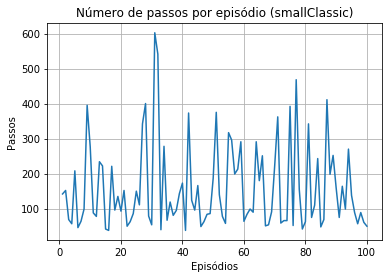

No passos máximo:  603 - No passos mínimo:  39
Número de partidas ganhas:  0


In [25]:
seed = 12540594
random.seed(seed)
input_str = "-l smallClassic -q"
args = readCommand(input_str.split())
agent_s = RL_AQ_Agent()
args['pacman'] = agent_s
layout = args['layout']

# Inicialização do agente
agent_s.m = layout.width
agent_s.n = layout.height
agent_s.total_food = layout.totalFood
agent1.reward_list = []
agent1.scores_list = []
agent1.nsteps_list = []
agent1.result_list = []

# Treinamento
n_episodes = 100
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent_s.scores_list.append(games[0].state.getScore())
    agent_s.nsteps_list.append(len(games[0].moveHistory))
    agent_s.result_list.append(games[0].state.isWin())
    agent_s.reward_list.append(agent_s.episode_reward)
    agent_s.episode_reward = 0
    if agent_s.epsilon >= 0.001:
        agent_s.epsilon -= 0.001
        
RL_aprox_best_small = agent_s.qtable

# Impressão de estatísticas
print("Treinamento smallClassic com a terceira formulação (aproximador de função)")
print("Número de episódios: ", n_episodes)
n_wins = 0
for jogada in agent_s.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent_s.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent_s.reward_list), "-", "Reward mínimo: ", min(agent_s.reward_list))
print_episodes_graph(n_episodes, agent_s.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent_s.scores_list), "-", "Score mínimo: ", min(agent_s.scores_list))
print_episodes_graph(n_episodes, agent_s.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent_s.nsteps_list), "-", "No passos mínimo: ", min(agent_s.nsteps_list))
print("Número de partidas ganhas: ", n_wins)

### 3.4.2 Layout mediumClassic

Executamos as três formulações propostas, imprimindo o número de episódios considerado para o treinamento, gráficos de reward por episódio, score por episódio, número de passos por episódio e, finalmente, o número de partidas ganhas.

##### $\rightarrow$ Primeira formulação: q-learning com estados definidos sobre o mapa completo

Treinamento mediumClassic com a primeira formulação (mapa completo)
Número de episódios:  1000


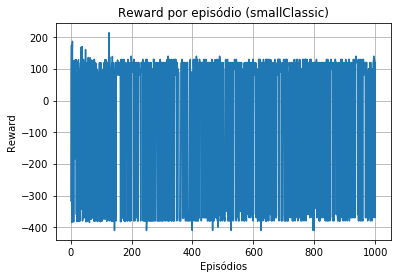

Reward máximo:  214 - Reward mínimo:  -410


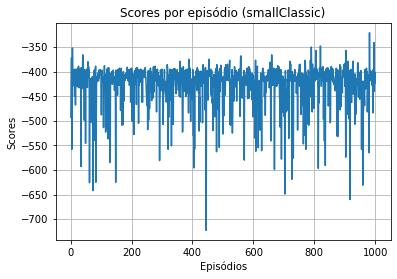

Score máximo:  -321.0 - Score mínimo:  -723.0


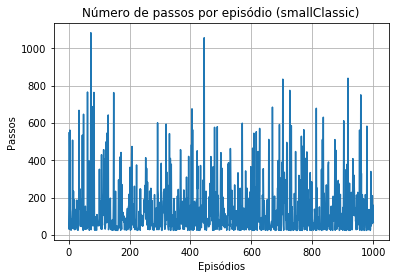

No passos máximo:  1084 - No passos mínimo:  24
Número de partidas ganhas:  0


In [18]:
seed = 489132164113
random.seed(seed)
input_str = "-l mediumClassic -q"
args = readCommand(input_str.split())
agent = RLAgent_full()
args['pacman'] = agent
layout = args['layout']

# Inicialização do agente
agent.m = layout.width
agent.n = layout.height
agent.reward_list = []
agent.scores_list = []
agent.nsteps_list = []
agent.result_list = []

# Treinamento
n_episodes = 1000
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent.scores_list.append(games[0].state.getScore())
    agent.nsteps_list.append(len(games[0].moveHistory))
    agent.result_list.append(games[0].state.isWin())
    agent.reward_list.append(agent.episode_reward)
    agent.episode_reward = 0
    if agent.epsilon >= 0.001:
        agent.epsilon -= 0.001
        
RL_full_best_medium = agent.qtable

# Impressão de estatísticas
print("Treinamento mediumClassic com a primeira formulação (mapa completo)")
print("Número de episódios: ", n_episodes)
n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1

print_episodes_graph(n_episodes, agent.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent.reward_list), "-", "Reward mínimo: ", min(agent.reward_list))
print_episodes_graph(n_episodes, agent.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent.scores_list), "-", "Score mínimo: ", min(agent.scores_list))
print_episodes_graph(n_episodes, agent.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent.nsteps_list), "-", "No passos mínimo: ", min(agent.nsteps_list))
#print_episodes_graph(n_episodes, agent.result_list, 'Resultado', 'Resultado final por episódio (smallClassic)')
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Segunda formulação: q-learning com estados definidos sobre o entorno do pacman

In [ ]:
seed = 5977139850
random.seed(seed)
input_str = "-l mediumClassic -q"
args = readCommand(input_str.split())
agent1 = RLAgent_mini()
args['pacman'] = agent1
layout = args['layout']

# Inicialização do agente
agent1.m = layout.width
agent1.n = layout.height
agent1.reward_list = []
agent1.scores_list = []
agent1.nsteps_list = []
agent1.result_list = []

# Treinamento
n_episodes = 100
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent1.scores_list.append(games[0].state.getScore())
    agent1.nsteps_list.append(len(games[0].moveHistory))
    agent1.result_list.append(games[0].state.isWin())
    agent1.reward_list.append(agent.episode_reward)
    agent1.episode_reward = 0
    if agent1.epsilon >= 0.001:
        agent1.epsilon -= 0.001

RL_mini_best_medium = agent1.qtable

# Impressão de estatísticas
print("Treinamento mediumClassic com a segunda formulação (entorno do pacman)")
print("Número de episódios: ", n_episodes)
n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent1.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent1.reward_list), "-", "Reward mínimo: ", min(agent1.reward_list))
print_episodes_graph(n_episodes, agent1.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent1.scores_list), "-", "Score mínimo: ", min(agent1.scores_list))
print_episodes_graph(n_episodes, agent1.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent1.nsteps_list), "-", "No passos mínimo: ", min(agent1.nsteps_list))
#print_episodes_graph(n_episodes, agent.result_list, 'Resultado', 'Resultado final por episódio (smallClassic)')
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Terceira formulação: q-learning com aproximador de função

In [ ]:
seed = 7891216801502
random.seed(seed)
input_str = "-l mediumClassic -q"
args = readCommand(input_str.split())
agent_m = RL_AQ_Agent()
args['pacman'] = agent_m
layout = args['layout']

# Inicialização do agente
agent_m.m = layout.width
agent_m.n = layout.height
agent_m.total_food = layout.totalFood
agent_m.reward_list = []
agent_m.scores_list = []
agent_m.nsteps_list = []
agent_m.result_list = []

# Treinamento
n_episodes = 5
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent_m.scores_list.append(games[0].state.getScore())
    agent_m.nsteps_list.append(len(games[0].moveHistory))
    agent_m.result_list.append(games[0].state.isWin())
    agent_m.reward_list.append(agent_m.episode_reward)
    agent_m.episode_reward = 0
    if agent_m.epsilon >= 0.001:
        agent_m.epsilon -= 0.001
        
RL_aprox_best_medium = agent_m.qtable

# Impressão de estatísticas
print("Treinamento mediumClassic com a terceira formulação (aproximador de função)")
print("Número de episódios: ", n_episodes)
n_wins = 0
for jogada in agent_m.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent_m.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent_m.reward_list), "-", "Reward mínimo: ", min(agent_m.reward_list))
print_episodes_graph(n_episodes, agent_m.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent_m.scores_list), "-", "Score mínimo: ", min(agent_m.scores_list))
print_episodes_graph(n_episodes, agent_m.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent_m.nsteps_list), "-", "No passos mínimo: ", min(agent_m.nsteps_list))
print("Número de partidas ganhas: ", n_wins)

### 3.4.2 Layout originalClassic

Executamos as três formulações propostas, imprimindo o número de episódios considerado para o treinamento, gráficos de reward por episódio, score por episódio, número de passos por episódio e, finalmente, o número de partidas ganhas.

##### $\rightarrow$ Primeira formulação: q-learning com estados definidos sobre o mapa completo

In [ ]:
seed = 498786512678
random.seed(seed)
input_str = "-l originalClassic -q"
args = readCommand(input_str.split())
agent = RLAgent_full()
args['pacman'] = agent
layout = args['layout']

# Inicialização do agente
agent.m = layout.width
agent.n = layout.height
agent.reward_list = []
agent.scores_list = []
agent.nsteps_list = []
agent.result_list = []

# Treinamento
n_episodes = 100
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent.scores_list.append(games[0].state.getScore())
    agent.nsteps_list.append(len(games[0].moveHistory))
    agent.result_list.append(games[0].state.isWin())
    agent.reward_list.append(agent.episode_reward)
    agent.episode_reward = 0
    if agent.epsilon >= 0.001:
        agent.epsilon -= 0.001
        
RL_full_best_original = agent.qtable

# IMpressão de estatísticas
print("Treinamento mediumClassic com a primeira formulação (mapa completo)")
print("Número de episódios: ", n_episodes)

n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent.reward_list), "-", "Reward mínimo: ", min(agent.reward_list))
print_episodes_graph(n_episodes, agent.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent.scores_list), "-", "Score mínimo: ", min(agent.scores_list))
print_episodes_graph(n_episodes, agent.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent.nsteps_list), "-", "No passos mínimo: ", min(agent.nsteps_list))
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Segunda formulação: q-learning com estados definidos sobre o entorno do pacman

Treinamento mediumClassic com a segunda formulação (entorno do pacman)
Número de episódios:  1


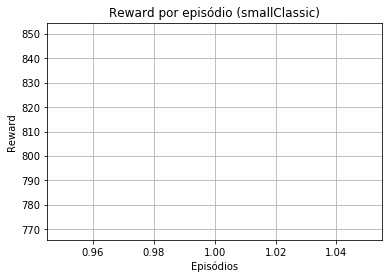

Reward máximo:  810 - Reward mínimo:  810


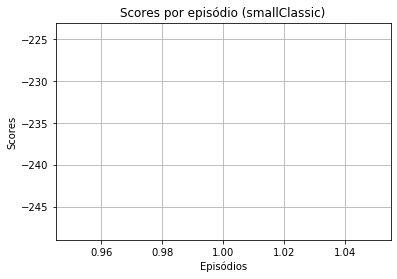

Score máximo:  -236.0 - Score mínimo:  -236.0


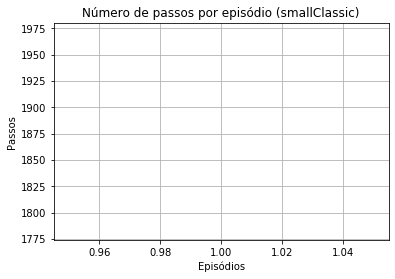

No passos máximo:  1877 - No passos mínimo:  1877
Número de partidas ganhas:  0


In [29]:
seed = 789119994054
random.seed(seed)
input_str = "-l originalClassic"
args = readCommand(input_str.split())
agent1 = RLAgent_mini()
args['pacman'] = agent1
layout = args['layout']

# Inicialização do agente
agent1.m = layout.width
agent1.n = layout.height
agent1.reward_list = []
agent1.scores_list = []
agent1.nsteps_list = []
agent1.result_list = []

# Treinamento
n_episodes = 1
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent1.scores_list.append(games[0].state.getScore())
    agent1.nsteps_list.append(len(games[0].moveHistory))
    agent1.result_list.append(games[0].state.isWin())
    agent1.reward_list.append(agent1.episode_reward)
    agent1.episode_reward = 0
    if agent1.epsilon >= 0.001:
        agent1.epsilon -= 0.001
        
RL_mini_best_original = agent1.qtable

# Impressão de estatísticas
print("Treinamento mediumClassic com a segunda formulação (entorno do pacman)")
print("Número de episódios: ", n_episodes)

n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent1.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent1.reward_list), "-", "Reward mínimo: ", min(agent1.reward_list))
print_episodes_graph(n_episodes, agent1.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent1.scores_list), "-", "Score mínimo: ", min(agent1.scores_list))
print_episodes_graph(n_episodes, agent1.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent1.nsteps_list), "-", "No passos mínimo: ", min(agent1.nsteps_list))
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Terceira formulação: q-learning com aproximador de função

In [ ]:
seed = 484981238123
random.seed(seed)
input_str = "-l originalClassic -q"
args = readCommand(input_str.split())
agent = RL_AQ_Agent()
args['pacman'] = agent
layout = args['layout']

# Inicialização do agente
agent.m = layout.width
agent.n = layout.height
agent.total_food = layout.totalFood
agent.reward_list = []
agent.scores_list = []
agent.nsteps_list = []
agent.result_list = []

# Treinamento
n_episodes = 5
for i in range(1,n_episodes+1):
    games = runGames(**args)
    agent.scores_list.append(games[0].state.getScore())
    agent.nsteps_list.append(len(games[0].moveHistory))
    agent.result_list.append(games[0].state.isWin())
    agent.reward_list.append(agent.episode_reward)
    agent.episode_reward = 0
    if agent.epsilon >= 0.001:
        agent.epsilon -= 0.001
        
RL_aprox_best_original = agent.qtable

# Impressão de estatísticas
print("Treinamento mediumClassic com a terceira formulação (aproximador de função)")
print("Número de episódios: ", n_episodes)

n_wins = 0
for jogada in agent.result_list:
    if jogada:
        n_wins += 1
print_episodes_graph(n_episodes, agent.reward_list, 'Reward', 'Reward por episódio (smallClassic)')
print("Reward máximo: ", max(agent.reward_list), "-", "Reward mínimo: ", min(agent.reward_list))
print_episodes_graph(n_episodes, agent.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(agent.scores_list), "-", "Score mínimo: ", min(agent.scores_list))
print_episodes_graph(n_episodes, agent.nsteps_list, 'Passos', 'Número de passos por episódio (smallClassic)')
print("No passos máximo: ", max(agent.nsteps_list), "-", "No passos mínimo: ", min(agent.nsteps_list))
print("Número de partidas ganhas: ", n_wins)

## 3.5 Melhores Modelos 
Nesta seção, escolhemos o melhor modelo obtido após o treinamento para cada mapa e, em seguida, executamos dez rodadas do jogo utilizando tal modelo como referência na tomada de decisão do pacman.

Observe que, para os três mapas, em nenhuma das três formulações o treinamento convergiu para um nível de desempenho satisfatório. Nos três casos, não houve nenhuma vitória na fase de treinamento. Sendo assim, optamos por escolher como o melhor modelo aquele que produziu o maior score máximo. A seguir, apresentamos os melhores modelos de cada um dos mapas, bem como seu desempenho nas dez partidas jpgadas.

##### $\rightarrow$ Melhor modelo para o mapa smallClassic
Para esse mapa, o melhor modelo foi o produzido pela segunda formulação, isto é, o uso do q-learning com os estados definidos sobre somente o entorno do pacman.

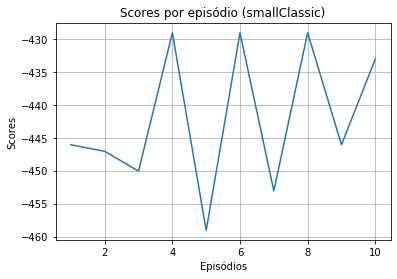

Score máximo:  -429.0 - Score mínimo:  -459.0
Número de partidas ganhas:  0


In [19]:
seed = 7986467
random.seed(seed)
input_str = "-l smallClassic -q"
args = readCommand(input_str.split())
player = RLplayer()
args['pacman'] = player
layout = args['layout']

player.m = layout.width
player.n = layout.height
player.qtable = RL_mini_best_small # seta a qtable para o melhor modelo

n_episodes = 10
for i in range(1,n_episodes+1):
    games = runGames(**args)
    player.scores_list.append(games[0].state.getScore())
    player.nsteps_list.append(len(games[0].moveHistory))
    player.result_list.append(games[0].state.isWin())
n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1
        
print_episodes_graph(n_episodes, player.scores_list, 'Scores', 'Scores por episódio (smallClassic)')
print("Score máximo: ", max(player.scores_list), "-", "Score mínimo: ", min(player.scores_list))
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Melhor modelo para o mapa mediumClassic
Para esse mapa, o melhor modelo foi o produzido pela X formulação, isto é, o uso do q-learning com os estados definidos sobre somente o entorno do pacman.

In [ ]:
seed = 7986467
random.seed(seed)
input_str = "-l mediumClassic -q"
args = readCommand(input_str.split())
player = RLplayer()
args['pacman'] = player
layout = args['layout']

player.m = layout.width
player.n = layout.height
player.qtable = RL_x_best_medium # seta a qtable para o melhor modelo

n_episodes = 10
for i in range(1,n_episodes+1):
    games = runGames(**args)
    player.scores_list.append(games[0].state.getScore())
    player.nsteps_list.append(len(games[0].moveHistory))
    player.result_list.append(games[0].state.isWin())
n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1
        
print_episodes_graph(n_episodes, player.scores_list, 'Scores', 'Scores por episódio (mediumClassic)')
print("Score máximo: ", max(player.scores_list), "-", "Score mínimo: ", min(player.scores_list))
print("Número de partidas ganhas: ", n_wins)

##### $\rightarrow$ Melhor modelo para o mapa originalClassic
Para esse mapa, o melhor modelo foi o produzido pela segunda formulação, isto é, o uso do q-learning com os estados definidos sobre somente o entorno do pacman.

In [ ]:
seed = 12816904
random.seed(seed)
input_str = "-l originalClassic -q"
args = readCommand(input_str.split())
player = RLplayer()
args['pacman'] = player
layout = args['layout']

player.m = layout.width
player.n = layout.height
player.qtable = RL_x_best_original # seta a qtable para o melhor modelo

n_episodes = 10
for i in range(1,n_episodes+1):
    games = runGames(**args)
    player.scores_list.append(games[0].state.getScore())
    player.nsteps_list.append(len(games[0].moveHistory))
    player.result_list.append(games[0].state.isWin())
n_wins = 0
for jogada in agent1.result_list:
    if jogada:
        n_wins += 1
        
print_episodes_graph(n_episodes, player.scores_list, 'Scores', 'Scores por episódio (originalClassic)')
print("Score máximo: ", max(player.scores_list), "-", "Score mínimo: ", min(player.scores_list))
print("Número de partidas ganhas: ", n_wins)

## 3.6 Conclusões

Os experimentos realizados revelam que as formulações definidas não são adequadas.
Na primeira formulação, tentamos uma abordagem que veio naturalmente em mente. Pensamos que, por ter todas as informações do mapa, o treinamento eventualmente iria convergir para um modelo razoável. No entanto, logo percebemos que essa abordagem não é escalável. Apesar disso, tentamos executar o treinamento também nos mapas maiores, mesmo utilizando um número menor de episódios para treinar. No entanto, não obtivemos bons resultados para nenhum dos mapas, nem mesmo no menor deles.

A partir dessa primeira ideia, pensamos em reduzir o espaço de estados e, por isso, tentamos a abordagem de considerar somente o entorno da posição corrente do pacman. Além de diminuir o número total de estados distintos, pensamos que essa formulação seria melhor pois, o mesmo estado poderia ocorrer em diferentes partes do mapa. Pensamos que esse fator melhoraria o desempenho do treinamento, mas os experimentos mostram que não houve melhora significativa, quando houve. A principal vantagem dessa abordagem é o tamanho reduzido do espaço de estados, possibilitando um aumento no número de episódios utilizados para o treinamento.

Como ambas abordagens anteriores não deram certo, tentamos aplicar outra estratégia, agregando o uso de aproximação de função ao algoritmo q-learning. Nesse caso, foi preciso definir funções que relacionam um estado e uma ação, que são chamadas de *features*. O espaço de ações foi o mesmo que o utilizado nas formulações anteriores. Contudo, novamente não obtivemos sucesso no treinamento. Julgamos que o principal fator que pode ter influenciado no mal desempenho do algoritmo foi o conjunto de *features*, que pode não ter sido adequado para que o treinamento convergisse.